Loading Data...
Original Feature Count: 39
Refined Feature Count: 25
Features kept: ['trip_duration_sec', 'n_points', 'speed_max', 'speed_mean', 'speed_std', 'pct_time_speed_over_80', 'pct_time_cruising', 'accel_mag_max', 'accel_mag_mean', 'accel_mag_std', 'jerk_linear_mean', 'n_hard_accels', 'n_hard_brakes', 'pct_time_high_accel', 'gyro_mag_max', 'gyro_mag_mean', 'gyro_mag_std', 'gyro_jerk_mag_mean', 'n_hard_turns', 'pct_time_high_gyro', 'n_zigzag_events', 'turn_sharpness_index', 'longest_smooth_segment_sec', 'pct_time_smooth', 'id']

>>> Tuning Refined Model: Logistic_Regression_V2
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 3 is smaller than n_iter=15. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase

   Best Params: {'penalty': 'l2', 'C': 0.1}
   Test Set AUC: 0.7330


2026/01/18 21:43:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Refined_Logistic_Regression_V2 at: http://localhost:5000/#/experiments/671472067514299670/runs/e2deef9e0b274e22a50f98479f8fedc7
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670

>>> Tuning Refined Model: Random_Forest_V2
Fitting 3 folds for each of 15 candidates, totalling 45 fits
   Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': None, 'bootstrap': True}
   Test Set AUC: 0.7012


2026/01/18 21:45:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Refined_Random_Forest_V2 at: http://localhost:5000/#/experiments/671472067514299670/runs/bdeeaf2bab124700a6058ae2aa6b2ebd
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670

>>> Tuning Refined Model: XGBoost_V2
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:46:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
   Test Set AUC: 0.6955


2026/01/18 21:46:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


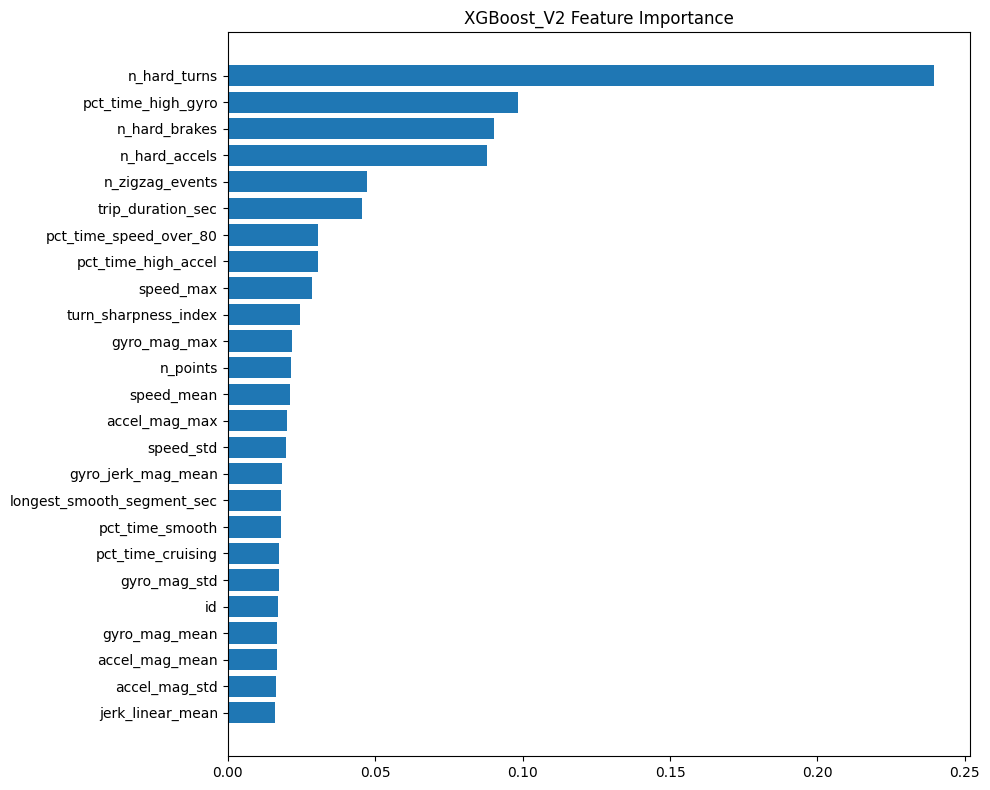

🏃 View run Refined_XGBoost_V2 at: http://localhost:5000/#/experiments/671472067514299670/runs/adf86de3a11c4e9091b4d884d2dcd66a
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670


=== AND THE WINNER IS: Logistic_Regression_V2 ===
Winning AUC: 0.7330

Saved '../models/final_model.pkl' and '../models/model_columns.pkl'
READY FOR GUI INTEGRATION.


In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import time
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP & REFINED DATA LOADING
# ==========================================
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Gobest_Cab_Safety_Prediction")

print("Loading Data...")
df = pd.read_csv("../data/bi_dataset.csv")

# --- THE REFINEMENT STEP (Optimization) ---
# We drop demographics to force the model to look at DRIVING BEHAVIOR.
# This makes the model more robust (generalizes better to new drivers).
weak_features = [
    'age', 'rating', 'no_of_years_driving_exp', 'car_model_year', 
    'gender', 'rating_bin', 'exp_bin', 'car_brand'
]

drop_cols = ['bookingID', 'driver_id', 'date_of_birth', 'name', 
             'is_dangerous', 'label'] + weak_features

# Filter to ensure we only drop what exists
existing_drop = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=existing_drop).fillna(0)
y = df['label']

print(f"Original Feature Count: {len(df.columns)}")
print(f"Refined Feature Count: {X.shape[1]}")
print(f"Features kept: {X.columns.tolist()}")

# Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ==========================================
# 2. DEFINE THE COMPETITORS (Version 2)
# ==========================================
# We use the same grids, but now they run on "Clean" data.

# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=2000)
log_param_dist = {'C': [0.1, 1, 10], 'penalty': ['l2']}

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'bootstrap': [True]
}

# XGBoost (The Heavy Hitter)
xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, use_label_encoder=False)
xgb_param_dist = {
    'n_estimators': [200, 400, 600],    # More trees for finer detail
    'max_depth': [4, 6, 8, 10],         # Control complexity
    'learning_rate': [0.01, 0.05, 0.1], # Slower learning often works better
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

competitors = [
    ("Logistic_Regression_V2", log_reg, log_param_dist),
    ("Random_Forest_V2", rf, rf_param_dist),
    ("XGBoost_V2", xgb, xgb_param_dist)
]

# ==========================================
# 3. THE GRAND TOURNAMENT (Round 2)
# ==========================================
best_overall_auc = 0
best_overall_model = None
best_overall_name = ""

for name, model, param_dist in competitors:
    print(f"\n>>> Tuning Refined Model: {name}")
    start_time = time.time()
    
    with mlflow.start_run(run_name=f"Refined_{name}"):
        # Tuning
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=15,          # 15 solid attempts per model
            scoring='roc_auc',
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        search.fit(X_train_res, y_train_res)
        
        # Capture Winner
        best_model = search.best_estimator_
        best_params = search.best_params_
        
        # Test
        if "XGBoost" in name:
            y_prob = best_model.predict_proba(X_test)[:, 1]
        else:
            y_prob = best_model.predict_proba(X_test)[:, 1]
            
        final_auc = roc_auc_score(y_test, y_prob)
        print(f"   Best Params: {best_params}")
        print(f"   Test Set AUC: {final_auc:.4f}")
        
        # Log
        mlflow.log_params(best_params)
        mlflow.log_metric("auc", final_auc)
        mlflow.log_param("features", "Refined_Sensor_Only")
        
        # Save Artifacts
        if "XGBoost" in name:
            mlflow.xgboost.log_model(best_model, "model")
            
            # Feature Importance Plot (Only for Tree models)
            plt.figure(figsize=(10, 8))
            sorted_idx = best_model.feature_importances_.argsort()
            plt.barh(X.columns[sorted_idx], best_model.feature_importances_[sorted_idx])
            plt.title(f"{name} Feature Importance")
            plt.tight_layout()
            plt.savefig(f"{name}_importance.png")
            mlflow.log_artifact(f"{name}_importance.png")
            plt.show()
            
        else:
            mlflow.sklearn.log_model(best_model, "model")
        
        # Check if this is the global winner
        if final_auc > best_overall_auc:
            best_overall_auc = final_auc
            best_overall_model = best_model
            best_overall_name = name

# ==========================================
# 4. SAVE THE CHAMPION
# ==========================================
print(f"\n\n=== AND THE WINNER IS: {best_overall_name} ===")
print(f"Winning AUC: {best_overall_auc:.4f}")

# Save the absolute best model for the GUI
joblib.dump(best_overall_model, "../models/final_model.pkl")
# Save the column list (CRITICAL for GUI robustness)
joblib.dump(X.columns.tolist(), "../models/model_columns.pkl")

print("\nSaved '../models/final_model.pkl' and '../models/model_columns.pkl'")
print("READY FOR GUI INTEGRATION.")

Loading Data...
Original Feature Count: 39
Aggressive Refined Count: 16
Features kept (The Heavy Hitters): 
['trip_duration_sec', 'n_points', 'speed_max', 'speed_mean', 'speed_std', 'pct_time_speed_over_80', 'accel_mag_max', 'n_hard_accels', 'n_hard_brakes', 'pct_time_high_accel', 'gyro_mag_max', 'gyro_jerk_mag_mean', 'n_hard_turns', 'pct_time_high_gyro', 'n_zigzag_events', 'turn_sharpness_index']

>>> Tuning Aggressive Model: Logistic_Regression_V3
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase

   Best Params: {'penalty': 'l2', 'C': 10}
   Test Set AUC: 0.7318


2026/01/18 22:05:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Aggressive_Logistic_Regression_V3 at: http://localhost:5000/#/experiments/671472067514299670/runs/f12909612496487c9162bc0978084099
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670

>>> Tuning Aggressive Model: Random_Forest_V3
Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


   Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'max_depth': None, 'bootstrap': True}
   Test Set AUC: 0.6983


2026/01/18 22:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Aggressive_Random_Forest_V3 at: http://localhost:5000/#/experiments/671472067514299670/runs/89db3d7d785b41cebb0994d90f1327c3
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670

>>> Tuning Aggressive Model: XGBoost_V3
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Thomas\Desktop\PAI CA2\gobest-cab-safety-sprint2\CA2_Sprint2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
   Test Set AUC: 0.6893


2026/01/18 22:08:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


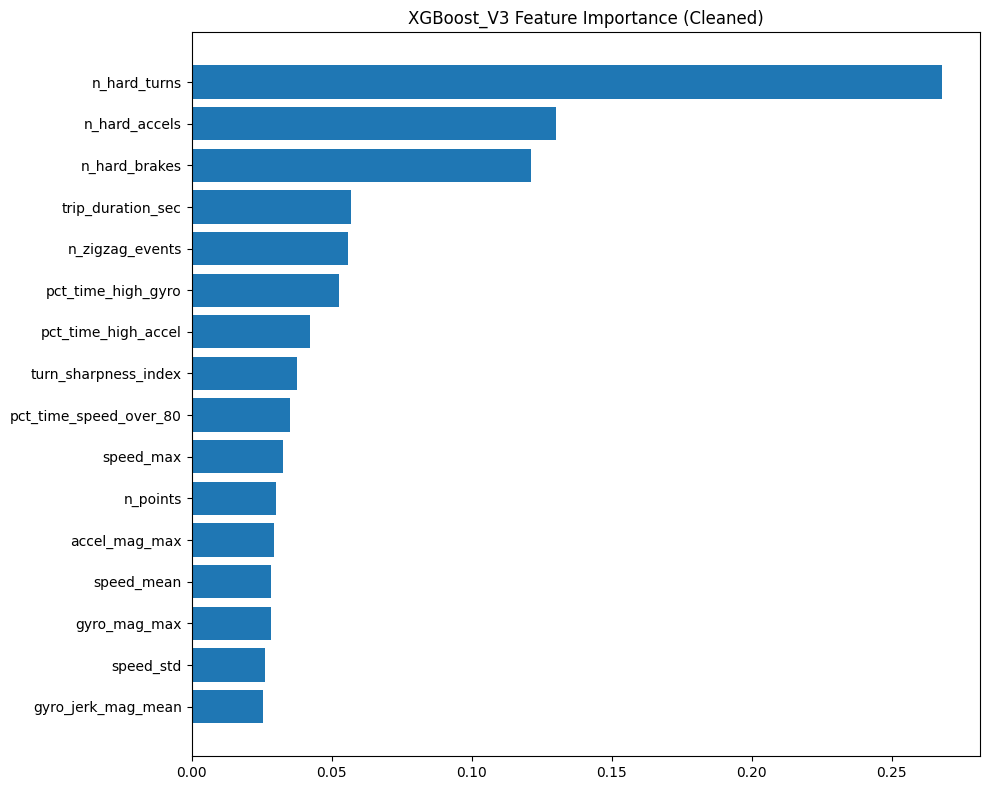

🏃 View run Aggressive_XGBoost_V3 at: http://localhost:5000/#/experiments/671472067514299670/runs/1993913c0d99427abb6cfc9f02b2fea2
🧪 View experiment at: http://localhost:5000/#/experiments/671472067514299670


=== AND THE WINNER IS: Logistic_Regression_V3 ===
Winning AUC: 0.7318

Saved '../models/final_model.pkl' and '../models/model_columns.pkl'


In [3]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import time
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP & AGGRESSIVE FEATURE SELECTION
# ==========================================
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Gobest_Cab_Safety_Prediction")

print("Loading Data...")
df = pd.read_csv("../data/bi_dataset.csv")

# --- THE "BOUNCER" LIST ---
# 1. Drop Demographics (Bias)
demographics = [
    'age', 'rating', 'no_of_years_driving_exp', 'car_model_year', 
    'gender', 'rating_bin', 'exp_bin', 'car_brand', 'driver_id', 
    'date_of_birth', 'name', 'is_dangerous', 'label', 'bookingID'
]

# 2. Drop Weak Sensor Features (Noise)
# Based on YOUR previous chart, these had very low importance scores.
# Removing them forces the model to focus on the big signals.
weak_signals = [
    'jerk_linear_mean',           # Bottom of your chart
    'accel_mag_std',              # Low importance
    'accel_mag_mean',             # Low importance
    'gyro_mag_mean',              # Low importance
    'gyro_mag_std',               # Low importance
    'pct_time_smooth',            # Low importance
    'pct_time_cruising',          # Low importance
    'longest_smooth_segment_sec', # Low importance
    'id'                          # Artifact
]

drop_cols = demographics + weak_signals

# Filter to ensure we only drop what exists
existing_drop = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=existing_drop).fillna(0)
y = df['label']

print(f"Original Feature Count: {len(df.columns)}")
print(f"Aggressive Refined Count: {X.shape[1]}")
print(f"Features kept (The Heavy Hitters): \n{X.columns.tolist()}")

# Split & SMOTE
# Note: Smaller feature sets often need less data to learn, reducing overfitting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ==========================================
# 2. DEFINE THE COMPETITORS (Version 3)
# ==========================================

# Logistic Regression (Often loves fewer features)
log_reg = LogisticRegression(solver='lbfgs', max_iter=3000)
log_param_dist = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']}

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'bootstrap': [True]
}

# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, use_label_encoder=False)
xgb_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1], 
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

competitors = [
    ("Logistic_Regression_V3", log_reg, log_param_dist),
    ("Random_Forest_V3", rf, rf_param_dist),
    ("XGBoost_V3", xgb, xgb_param_dist)
]

# ==========================================
# 3. THE GRAND TOURNAMENT (Round 3)
# ==========================================
best_overall_auc = 0
best_overall_model = None
best_overall_name = ""

for name, model, param_dist in competitors:
    print(f"\n>>> Tuning Aggressive Model: {name}")
    start_time = time.time()
    
    with mlflow.start_run(run_name=f"Aggressive_{name}"):
        # Tuning
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=20,          # 20 attempts per model (increased slightly)
            scoring='roc_auc',
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        search.fit(X_train_res, y_train_res)
        
        # Capture Winner
        best_model = search.best_estimator_
        best_params = search.best_params_
        
        # Test
        if "XGBoost" in name:
            y_prob = best_model.predict_proba(X_test)[:, 1]
        else:
            y_prob = best_model.predict_proba(X_test)[:, 1]
            
        final_auc = roc_auc_score(y_test, y_prob)
        print(f"   Best Params: {best_params}")
        print(f"   Test Set AUC: {final_auc:.4f}")
        
        # Log
        mlflow.log_params(best_params)
        mlflow.log_metric("auc", final_auc)
        mlflow.log_param("features", "Aggressive_Selection_Top15")
        
        # Save Artifacts
        if "XGBoost" in name:
            mlflow.xgboost.log_model(best_model, "model")
            
            # Plot Importance AGAIN to see if it stabilized
            plt.figure(figsize=(10, 8))
            sorted_idx = best_model.feature_importances_.argsort()
            plt.barh(X.columns[sorted_idx], best_model.feature_importances_[sorted_idx])
            plt.title(f"{name} Feature Importance (Cleaned)")
            plt.tight_layout()
            plt.savefig(f"{name}_importance_v3.png")
            mlflow.log_artifact(f"{name}_importance_v3.png")
            plt.show()
            
        else:
            mlflow.sklearn.log_model(best_model, "model")
        
        # Check if this is the global winner
        if final_auc > best_overall_auc:
            best_overall_auc = final_auc
            best_overall_model = best_model
            best_overall_name = name

# ==========================================
# 4. SAVE THE CHAMPION
# ==========================================
print(f"\n\n=== AND THE WINNER IS: {best_overall_name} ===")
print(f"Winning AUC: {best_overall_auc:.4f}")

# Save the absolute best model for the GUI
joblib.dump(best_overall_model, "../models/final_model.pkl")
# Save the column list (CRITICAL for GUI robustness)
joblib.dump(X.columns.tolist(), "../models/model_columns.pkl")

print("\nSaved '../models/final_model.pkl' and '../models/model_columns.pkl'")